In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/open.zip"

In [2]:
# # 사용 가능한 GPU 확인
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# # GPU 사용 설정
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# from tensorflow.data import from_tensor_slices as tf_from_tensor_slices (에러 발생)
from tensorflow.keras.layers import BatchNormalization as keras_BatchNormalization
from tensorflow.data.experimental import cardinality as tf_cardinality
from tensorflow.keras.models import Sequential as keras_Sequential
from tensorflow.keras.layers import MaxPool2D as keras_MaxPool2D
from tensorflow.keras.layers import Flatten as keras_Flatten
from tensorflow.keras.layers import Dropout as keras_Dropout
from tensorflow.keras.layers import Conv2D as keras_Conv2D
from tensorflow.keras.optimizers import SGD as keras_SGD
from tensorflow.keras.layers import Dense as keras_Dense
from tensorflow.data import Dataset as tf_Dataset
from PIL import ImageFile as pil_ImageFile
import matplotlib.pyplot as mat_plt
from datetime import datetime
import pandas as pd

import os
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/functions')
# sys.path.append(os.path.join(os.getcwd(), os.path.pardir, 'functions'))
from get_train_list import get_train_image_paths_and_encoding_labels_fn
from predict_and_test import get_predict_result_fn, get_test_csv_fn
from get_img_tensor_v2 import get_tensor_through_imgs_fn

In [4]:
# ======== 학습용 이미지 경로와 라벨에 대한 각각의 리스트 생성하기 ========

train_image_paths, encoding_labels = get_train_image_paths_and_encoding_labels_fn()

# =====================================================================

encoding_labels.shape : (3457, 19)


In [5]:
# ========= 교수님 코드 따라서 이미지 데이터를 가져오고 차원 변형하기 =========

# 잘린 이미지에 대한 로드 여부 설정
pil_ImageFile.LOAD_TRUNCATED_IMAGES = True

RESIZED_WIDTH = 227
RESIZED_HEIGHT = 227

train_image_tensor = get_tensor_through_imgs_fn(train_image_paths, RESIZED_WIDTH, RESIZED_HEIGHT)
print('train_image_tensor.shape :', train_image_tensor.shape)

# =========================================================================

100%|██████████| 3457/3457 [01:04<00:00, 53.84it/s]


train_image_tensor.shape : (3457, 227, 227, 3)


In [6]:
# ========================== Alexnet 코드 따라서 학습시키기 ==========================
# https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

# v4.1.1 데이콘 리더 보드 점수 => 0.384591011

# 최종 수정 2023.05.16 (실행일 동일)
# 해당 코드는 코랩 GPU A100 고용량 RAM에서 실행시킨 결과이며 v4.1.1 버전에서 리팩토링만 진행하였음

EPOCHS = 50

train_ds = tf_Dataset.from_tensor_slices(
    (train_image_tensor, encoding_labels))

train_ds_size = tf_cardinality(train_ds).numpy()
print("Training data size:", train_ds_size)

train_ds = (train_ds
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32, drop_remainder=True))

model = keras_Sequential([
    keras_Conv2D(filters=96, kernel_size=(11, 11), strides=(
        4, 4), activation='relu', input_shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3)),
    keras_BatchNormalization(),
    keras_MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    keras_Conv2D(filters=256, kernel_size=(
        5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras_BatchNormalization(),
    keras_MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    keras_Conv2D(filters=384, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras_BatchNormalization(),
    keras_Conv2D(filters=384, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras_BatchNormalization(),
    keras_Conv2D(filters=256, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras_BatchNormalization(),
    keras_MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    keras_Flatten(),
    keras_Dense(4096, activation='relu'),
    keras_Dropout(0.5),
    keras_Dense(4096, activation='relu'),
    keras_Dropout(0.5),
    keras_Dense(19, activation='softmax')
])

print('weights :', model.get_weights())
model.compile(loss='categorical_crossentropy',
              optimizer=keras_SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

# fit() 함수의 default : batch_size = 32
history = model.fit(train_ds, epochs=EPOCHS)

# 연월일_시간
now = datetime.today().strftime('%Y%m%d_%H%M%S')
model.save(f'model_{now}.h5')

# ===================================================================================


Training data size: 3457
weights : [array([[[[-7.02634640e-03,  9.12642106e-04, -1.28512140e-02, ...,
           7.57410005e-03, -6.29900768e-03,  1.88729372e-02],
         [-2.15033311e-02, -5.91369346e-04, -1.25703551e-02, ...,
           5.89903630e-03, -2.15283222e-03,  6.11468591e-03],
         [ 4.14075516e-03, -2.14912724e-02,  1.06881466e-02, ...,
           1.66420452e-03,  1.16917137e-02, -1.61321349e-02]],

        [[ 1.87546480e-02, -1.22530414e-02,  1.85006503e-02, ...,
          -1.98211074e-02,  1.28390472e-02, -1.27916075e-02],
         [ 1.49704311e-02, -1.32852821e-02,  8.89996998e-03, ...,
           1.53372418e-02, -3.90571542e-03, -5.67572564e-03],
         [-1.34247085e-02, -3.92263941e-03, -1.41938906e-02, ...,
           2.05280129e-02,  2.15301458e-02,  1.20155010e-02]],

        [[-1.50658358e-02,  1.50714125e-02,  2.67952494e-03, ...,
           1.85855646e-02,  8.34061950e-03, -2.11499259e-02],
         [-6.30599819e-03, -2.58297287e-03, -1.80699062e-02, ...

loss : [3.2469866275787354, 2.5581510066986084, 2.191218137741089, 1.9648503065109253, 1.8188420534133911, 1.73184072971344, 1.603176236152649, 1.5438342094421387, 1.4587438106536865, 1.4037275314331055, 1.3530855178833008, 1.2616678476333618, 1.207694172859192, 1.1602473258972168, 1.1255314350128174, 1.095812439918518, 1.0407962799072266, 0.9976518154144287, 0.9609840512275696, 0.9474295377731323, 0.8992493152618408, 0.8554749488830566, 0.8321341276168823, 0.786379337310791, 0.7513909339904785, 0.7410552501678467, 0.7106784582138062, 0.66793292760849, 0.6518383622169495, 0.640527069568634, 0.6093140840530396, 0.581798255443573, 0.5439103245735168, 0.5101273655891418, 0.5172753930091858, 0.49197983741760254, 0.4705795645713806, 0.45026087760925293, 0.4350181519985199, 0.4167577624320984, 0.4102080166339874, 0.3725891709327698, 0.35586974024772644, 0.3436237871646881, 0.3434135317802429, 0.31874579191207886, 0.30586162209510803, 0.27548229694366455, 0.26124250888824463, 0.26028323173522

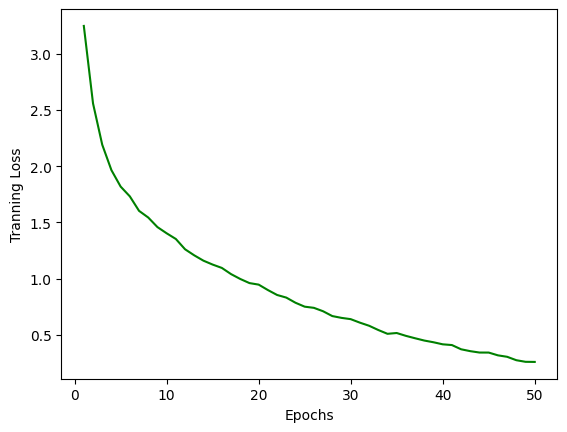

In [7]:
# ======= 학습 횟수에 따른 오차 변화 그래프 =======

loss = history.history['loss']
print('loss :', loss)

mat_plt.plot(range(1, EPOCHS + 1), loss, 'g')
mat_plt.title = 'Tranning Loss'
mat_plt.ylabel('Tranning Loss')
mat_plt.xlabel('Epochs')
mat_plt.show()

# ===============================================

In [8]:
# ================== 테스트 파일로 추론해보기 ==================

predicted_result = get_predict_result_fn(RESIZED_WIDTH, RESIZED_HEIGHT, model, 'v2')
csv_file_name = get_test_csv_fn(predicted_result, 'v4_AlexNet')

# ============================================================

100%|██████████| 792/792 [00:14<00:00, 55.40it/s]


test_image_tensor.shape : (792, 227, 227, 3)
25/25 [==============================] - 0s 13ms/step
predicted_result.shape : (792, 19)
predicted_labels : ['오염', '훼손', '오염', '가구수정', '훼손', '오염', '오염', '훼손', '오염', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '꼬임', '오염', '훼손', '꼬임', '훼손', '오타공', '훼손', '훼손', '훼손', '오염', '오염', '훼손', '몰딩수정', '곰팡이', '꼬임', '오염', '훼손', '오염', '오타공', '훼손', '훼손', '훼손', '훼손', '걸레받이수정', '훼손', '오염', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '이음부불량', '훼손', '석고수정', '훼손', '걸레받이수정', '훼손', '훼손', '오염', '걸레받이수정', '훼손', '훼손', '오염', '훼손', '훼손', '걸레받이수정', '걸레받이수정', '꼬임', '훼손', '훼손', '훼손', '걸레받이수정', '훼손', '오염', '훼손', '훼손', '오염', '훼손', '훼손', '몰딩수정', '곰팡이', '훼손', '훼손', '훼손', '훼손', '오염', '터짐', '훼손', '오염', '훼손', '오염', '오염', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '곰팡이', '오염', '몰딩수정', '훼손', '들뜸', '오염', '오염', '오염', '훼손', '오타공', '오염', '몰딩수정', '오염', '오염', '훼손', '훼손', '몰딩수정', '훼손', '훼손', '훼손', '곰팡이', '터짐', '오타공', '피스', '훼손', '꼬임', '훼손', '꼬임', '훼손', '오염', '훼손', '오염', '훼손', '훼손', '훼손', '꼬임', '오타공'

In [9]:
predicted_defect_types = pd.read_csv(csv_file_name)
print('predicted_defect_types :')
print(predicted_defect_types['label'].value_counts())

predicted_defect_types :
훼손         432
오염         164
오타공         36
걸레받이수정      33
꼬임          31
몰딩수정        23
곰팡이         19
터짐          18
들뜸           8
이음부불량        5
피스           5
창틀,문틀수정      5
면불량          5
석고수정         4
가구수정         3
울음           1
Name: label, dtype: int64


In [1]:
# v4.1.1 csv 파일과 비교
predicted_defect_types = pd.read_csv('v4_1_1_AlexNet_test_20230501_143734.csv')
print('predicted_defect_types :')
print(predicted_defect_types['label'].value_counts())

predicted_defect_types :
label
훼손         345
오염         208
곰팡이         36
걸레받이수정      34
오타공         34
터짐          24
꼬임          24
몰딩수정        23
면불량         16
창틀,문틀수정     10
석고수정         7
들뜸           7
피스           7
울음           5
가구수정         5
이음부불량        5
반점           1
녹오염          1
Name: count, dtype: int64
